# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Import dataset from Heroku

In [2]:
from getpass import getpass
password = getpass('Enter database password')

connection = psycopg2.connect(user="azcaqpdjrciaow",
                                  password=password,
                                  host="ec2-34-226-18-183.compute-1.amazonaws.com",
                                  port="5432",
                                  database="d7m85rf8c5rhv5")
cursor = connection.cursor()
postgreSQL_select_Query = "select * from player_market_values where season = 2018 or season = 2017"

cursor.execute(postgreSQL_select_Query)
print("Loading data from Heroku")

data = cursor.fetchall()
df = pd.DataFrame(data, columns=['player_id', 'player_name', 'age', 'club_id', \
                                                    'team_from', 'league_from', 'team_to', 'country_of_birth', \
                                                    'country_of_citizenship', 'player_position', 'games', 'goals', \
                                                    'assists', 'hours_played', 'yellow_cards', 'red_cards', 'transfer_fee', \
                                                    'market_value', 'club_market_value', 'season'])
Football_df = df.drop(columns=['player_id', 'player_name', 'club_id', 'team_from', 'league_from', 'team_to', 'country_of_birth', 'country_of_citizenship', 'season'])
Football_df

Enter database password··········
Loading data from Heroku


,age,player_position,games,goals,assists,hours_played,yellow_cards,red_cards,transfer_fee,market_value,club_market_value
0,25,Attack,27,25,16,40.4500,8,0,222000000,100000000,891180000
1,33,Attack,43,28,10,60.7667,4,1,117000000,100000000,816530000
2,25,Midfield,42,21,15,49.8833,1,0,125000000,90000000,604800000
3,22,Midfield,43,3,6,43.5333,5,0,70000000,65000000,671310000
4,25,Goalkeeper,51,0,0,76.5000,1,0,62500000,60000000,779850000
...,...,...,...,...,...,...,...,...,...,...,...
344,20,Midfield,1,0,0,0.1500,0,0,10000000,800000,301820000
345,20,Midfield,1,0,0,1.5000,0,0,5000000,800000,373820000
346,19,Attack,1,0,0,0.2500,0,0,5000000,800000,9050000
347,22,Defender,22,0,1,29.7333,3,0,5000000,600000,98420000


# Encoding categorical variables
#### hours_played converted to float
#### player_position to dummie variables

In [3]:
Football_df["hours_played"] = pd.to_numeric(Football_df.hours_played, downcast="float")
Football_cat= Football_df.dtypes[Football_df.dtypes == "object"].index.tolist()
Football_cat

['player_position']

In [4]:
Football_df.player_position.value_counts() # Position 0 to delete in the model

Attack        124
Midfield      106
Defender      101
Goalkeeper     17
0               1
Name: player_position, dtype: int64

In [5]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Football_df[Football_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(Football_cat)
encode_df.head()

,player_position_0,player_position_Attack,player_position_Defender,player_position_Goalkeeper,player_position_Midfield
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0


In [6]:
# Merge one-hot encoded features and drop the originals
Football_df = Football_df.merge(encode_df, left_index=True, right_index=True)
Football_df.drop(Football_cat,1, inplace=True)
Football_df.head()

,age,games,goals,assists,hours_played,yellow_cards,red_cards,transfer_fee,market_value,club_market_value,player_position_0,player_position_Attack,player_position_Defender,player_position_Goalkeeper,player_position_Midfield
0,25,27,25,16,40.450001,8,0,222000000,100000000,891180000,0.0,1.0,0.0,0.0,0.0
1,33,43,28,10,60.766701,4,1,117000000,100000000,816530000,0.0,1.0,0.0,0.0,0.0
2,25,42,21,15,49.883301,1,0,125000000,90000000,604800000,0.0,0.0,0.0,0.0,1.0
3,22,43,3,6,43.533298,5,0,70000000,65000000,671310000,0.0,0.0,0.0,0.0,1.0
4,25,51,0,0,76.500000,1,0,62500000,60000000,779850000,0.0,0.0,0.0,1.0,0.0


# Correlation plot
#### Variables related to market value: transfer_fee, club_market_value, assists, goals, games, hours_played

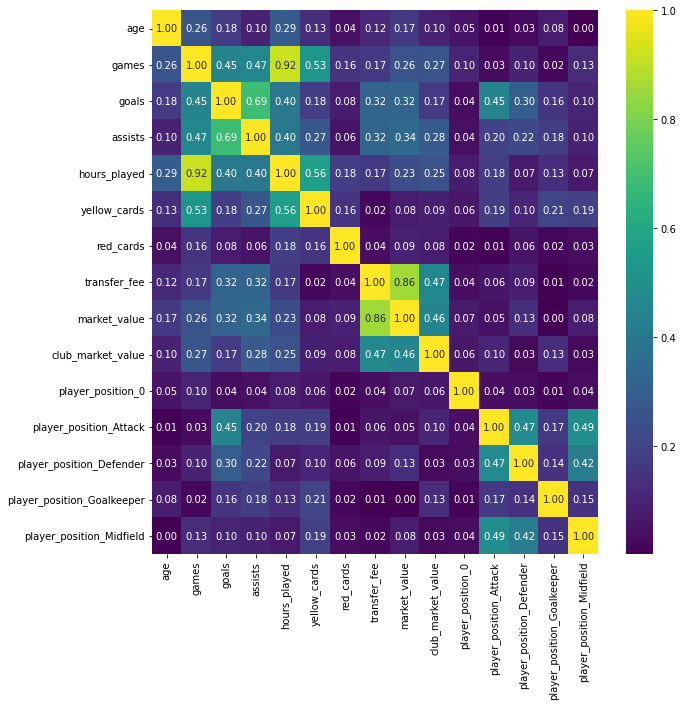

In [7]:
Football_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(np.abs(Football_df.corr()), annot=True, cmap="viridis", fmt="0.2f")

# Use pycaret to load the dessign matrix and test it with multiple classifiers
### fold_shuffle=True
### normalize=True
### train_size=0.8

In [ ]:
#!pip install pycaret

In [8]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [9]:
from pycaret.regression import *

In [10]:
exp_reg101 = setup(data = Football_df, target = 'market_value', session_id=123, fold_shuffle=True, normalize=True, train_size=0.8, ignore_features=['player_position_0'], \
                   numeric_features= ['age', 'yellow_cards', 'red_cards', 'assists', 'player_position_Attack', 'player_position_Defender', 'player_position_Goalkeeper', 'player_position_Midfield']) 

,Description,Value
0,session_id,123
1,Target,market_value
2,Original Data,"(349, 15)"
3,Missing Values,False
4,Numeric Features,13
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(279, 13)"


In [11]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,4.769633e+06,5.497267e+13,7.138271e+06,0.6747,0.6583,0.7881,0.013
gbr,Gradient Boosting Regressor,4.672110e+06,4.741148e+13,6.790948e+06,0.6708,0.6130,0.6603,0.066
ridge,Ridge Regression,4.745178e+06,5.409057e+13,7.177349e+06,0.6636,0.6271,0.6900,0.013
lasso,Lasso Regression,4.742169e+06,5.433800e+13,7.187153e+06,0.6633,0.6269,0.6840,0.017
et,Extra Trees Regressor,4.714318e+06,4.957047e+13,6.873664e+06,0.6632,0.5926,0.6166,0.409
lar,Least Angle Regression,4.742248e+06,5.392975e+13,7.184783e+06,0.6627,0.6422,0.6678,0.016
lr,Linear Regression,4.744089e+06,5.439101e+13,7.191123e+06,0.6625,0.6271,0.6840,0.284
llar,Lasso Least Angle Regression,4.746121e+06,5.444943e+13,7.195463e+06,0.6617,0.6272,0.6841,0.015
rf,Random Forest Regressor,4.795618e+06,5.240442e+13,7.105539e+06,0.6536,0.6011,0.6407,0.464
ada,AdaBoost Regressor,5.028865e+06,5.269028e+13,7.108463e+06,0.6376,0.7050,0.9112,0.077


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)

# Testing with the highest performance model (Orthogonal Matching Pursuit)

In [12]:
omp=create_model('omp',fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.991487e+06,4.765442e+13,6.903218e+06,0.6893,0.7445,0.9691
1,5.438284e+06,1.626036e+14,1.275161e+07,0.4664,0.5056,0.4434
2,4.706605e+06,5.817917e+13,7.627527e+06,0.8300,0.7165,0.9182
3,4.998667e+06,5.547595e+13,7.448218e+06,0.5245,0.7046,0.8647
4,5.446728e+06,5.103311e+13,7.143746e+06,0.8469,0.6273,0.7182
5,4.192200e+06,2.977673e+13,5.456806e+06,0.8086,0.6113,0.6964
6,4.009343e+06,3.042683e+13,5.516052e+06,0.6202,0.7470,0.9604
7,4.580559e+06,3.655924e+13,6.046424e+06,0.4716,0.5842,0.6351
8,4.990171e+06,4.050478e+13,6.364337e+06,0.7170,0.7331,0.9533
9,4.342283e+06,3.751283e+13,6.124772e+06,0.7720,0.6088,0.7225


In [13]:
tuned_omp=tune_model(omp, fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.725142e+06,4.310153e+13,6.565176e+06,0.7190,0.6761,0.8025
1,5.157087e+06,1.480374e+14,1.216706e+07,0.5142,0.5092,0.4397
2,4.750127e+06,5.724252e+13,7.565879e+06,0.8328,0.7172,0.9133
3,5.131489e+06,5.877207e+13,7.666295e+06,0.4963,0.7162,0.8646
4,4.862548e+06,4.605423e+13,6.786326e+06,0.8618,0.5420,0.5633
5,4.049063e+06,3.076503e+13,5.546623e+06,0.8023,0.6154,0.6538
6,4.107038e+06,3.139487e+13,5.603113e+06,0.6081,0.6768,0.8317
7,4.894400e+06,4.016075e+13,6.337251e+06,0.4195,0.5299,0.5512
8,4.898616e+06,3.881804e+13,6.230412e+06,0.7288,0.7226,0.9299
9,4.134795e+06,3.331565e+13,5.771971e+06,0.7975,0.5694,0.6224


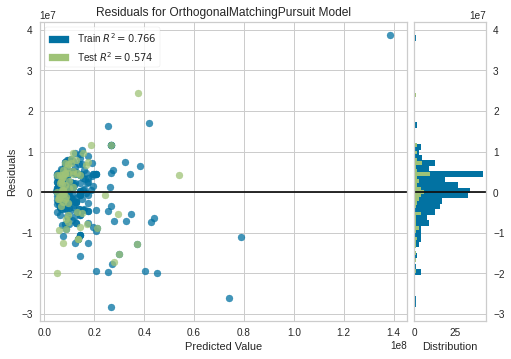

In [14]:
plot_model(omp)

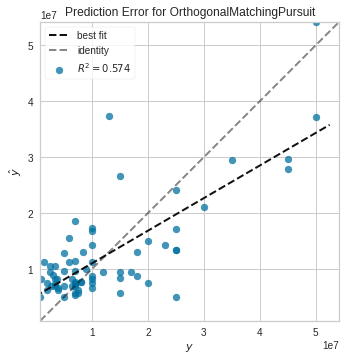

In [15]:
plot_model(omp, 'error')

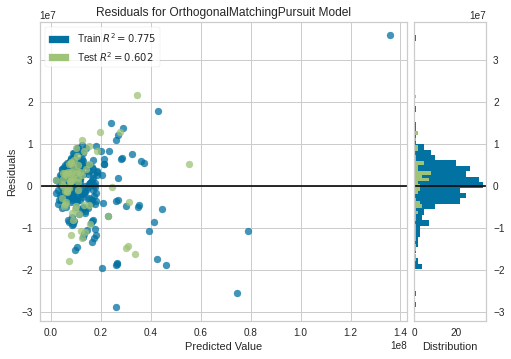

In [16]:
plot_model(tuned_omp)

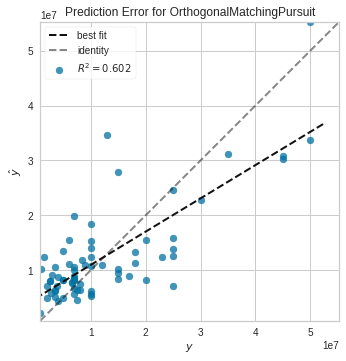

In [17]:
plot_model(tuned_omp, 'error')

# Testing with linear regression model

In [18]:
lr=create_model('lr',fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.719056e+06,4.501706e+13,6.709475e+06,0.7065,0.6620,0.7836
1,4.845320e+06,1.372936e+14,1.171724e+07,0.5495,0.4539,0.4211
2,5.157652e+06,5.800412e+13,7.616044e+06,0.8305,0.7155,0.8976
3,5.012943e+06,5.434949e+13,7.372211e+06,0.5342,0.6911,0.7233
4,5.284541e+06,5.600103e+13,7.483384e+06,0.8320,0.6413,0.6128
5,3.915509e+06,3.139386e+13,5.603023e+06,0.7982,0.5990,0.5699
6,4.367566e+06,3.531021e+13,5.942240e+06,0.5592,0.6509,0.7929
7,5.049267e+06,4.487603e+13,6.698957e+06,0.3514,0.5265,0.5154
8,5.055648e+06,4.427355e+13,6.653837e+06,0.6907,0.7404,0.8987
9,4.033388e+06,3.739109e+13,6.114825e+06,0.7727,0.5901,0.6250


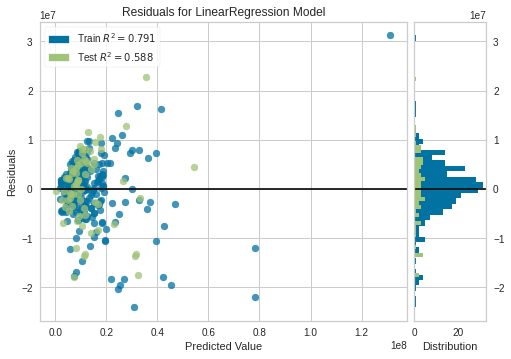

In [19]:
plot_model(lr)

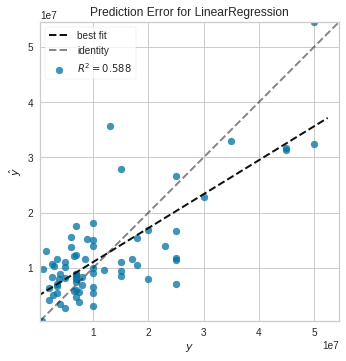

In [20]:
plot_model(lr, 'error')

# Testing with Gradient Boosting Regressor

In [21]:
gbr=create_model('gbr',fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.352245e+06,4.302915e+13,6.559661e+06,0.7195,0.6948,0.8949
1,3.410294e+06,3.849348e+13,6.204312e+06,0.8737,0.4147,0.3791
2,3.868205e+06,2.594246e+13,5.093375e+06,0.9242,0.6050,0.6816
3,4.829044e+06,6.066364e+13,7.788687e+06,0.4801,0.6236,0.6584
4,5.792355e+06,9.174488e+13,9.578355e+06,0.7247,0.6590,0.5937
5,4.978363e+06,4.295133e+13,6.553726e+06,0.7240,0.6499,0.7380
6,4.119707e+06,3.756690e+13,6.129184e+06,0.5310,0.6397,0.7239
7,5.812327e+06,4.958123e+13,7.041394e+06,0.2834,0.6153,0.6786
8,5.037455e+06,4.562884e+13,6.754912e+06,0.6812,0.6731,0.7106
9,4.521105e+06,3.851292e+13,6.205878e+06,0.7659,0.5546,0.5444


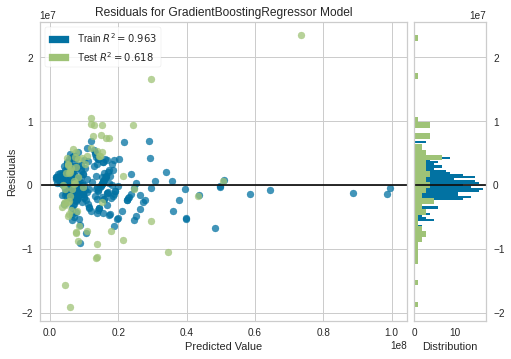

In [22]:
plot_model(gbr)

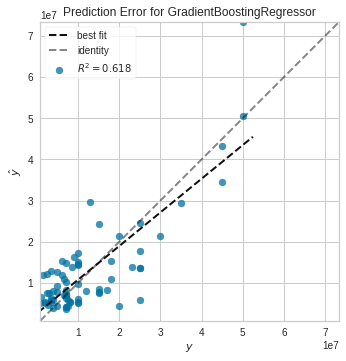

In [23]:
plot_model(gbr, 'error')